### Noms et Prénoms du binôme :
- Hadrien SALEM
- Emilie SALEM
---

# TP en Watermarking - TP2

---

## Patrick Bas, CNRS, CRIStAL

---


 

## Tatouage par également de spectre et attaques de sécurité

### 2.1 Notations et rappels:

Les notations sont identiques à celles vues en cours. Le procédé d'insertion est le schéma par étalement de spectre vu en cours.

* X = matrice de $N_{i}$ vecteurs originaux de taille $N_{v}$ ($N_{i}$ colonnes, $N_{v}$ lignes). $N_{i}$ représente par exemple le nombre de contenu traités, et $N_{v}$ le nombre de composantes tatouées par contenu. **Note**: chaque colonne de X peut par exemple représenter des composantes d'une image.
* $N_{o}$ représente le nombre de contenus tatoués observés par l'adversaire et utilisés pour construire son attaque
* $N_{i}$ représente le nombre de contenus tatoués utilisés pour calculer pratiquement le taux d'erreur (voir BER)
* Y = matrice de contenus tatoués
* Z = matrice de contenus tatoués et perturbés
* k clé secrète de norme unitaire
* $m_{1}$: bit inséré, converti en +1, -1 
* $\alpha$: paramètre de distorsion
* BER: Bit Error Rate, taux d'erreur binaire ou encore probabilité d'erreur empirique de décodage
* DWR: « Document to Watermark Ratio » $DWR=10\log_{10}(\sum x_{i}^{2}/\sum w_{i}^{2})$, permet de mesurer la distorsion ($DWR=0$ $\Leftrightarrow$ $\sigma_{X}^{2}=\sigma_{W}^{2}$ ). Permet de mesurer la distortion. Distortion nulle $DWR=\infty$, distortion importante $DWR \rightarrow 0$ 

#### Rappels:
* L'objectif du récepteur est de bien décoder $m_{1}$, possiblement en ayant une distortion qui ne soit pas trop importante
* Ici, les objectifs de l'adversaire sont d'estimer la clé k puis d'effacer le message inséré. Pour s'assurer que l'adversaire a bien réussi à estimer la clé, il calculera la correlation normalisée entre le vecteur k et son estimation.

**N'oubliez pas d'exporter votre TP en html lors de sa remise**


In [136]:
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from sklearn.decomposition import FastICA

## Scénario 1: Attaque à Messages connus, 1 bit
* Mise en route: Quel est le BER cible de l'adversaire ?
* Mettre en place l'attaque liée à ce scénario
* Etudier l'impact de $N_{o}$ et de $\alpha$ sur le BER après attaque

## Réponses 

- Le BER cible de l'adversaire est de $0.5$ : en effet, si le contenu n'est pas tatoué, on fait une erreur sur deux lors du décodage du message. Autrement dit, on ne peut plus retrouver le message inséré (puisque le message inséré a été effacé).
- Voir code ci-dessous, en particulier l'implémentation de `hatk` en utilisant la formule : 
  $$
  \hat k_1 = \frac{1}{\alpha N_o} \sum - (-1)^m y_i
  $$
- Comme on peut le voir sur la courbe "`BER après attaque en fonction du nombre No d'observations utilisées`", plus $N_o$ augmente plus le BER se rapproche de la valeur cible $0.5$. En effet, plus on fait d'observations, mieux on est capable d'estimer la valeur de $k$ (moyenne empirique) ce qui permet de retirer le message $m$ efficacement.
- La courbe "`BER après attaque en fonction du coefficient alpha`" montre que plus le coefficient $\alpha$ augmente, plus on semble se rapprocher et osciller autour de la valeur cible $0.5$. En effet, plus le coefficient de distorsion est important, plus il est facile de déterminer la direction correspondant à la clé (vecteurs bien polarisés).

In [137]:
Nv = 100 # Size of the vector
Ni = 10000 # Max number of observations

In [138]:
def ber(Y,m,k):# Compute the Bit Error Rate between message m and the extracted message from Y using key k
    c = np.sign(np.dot(Y.T,k))
    return np.sum(c != m)/np.float(Ni)

def norm_corr(hatk,k): # Correlation between k and its estimate
    hatk = hatk / np.sqrt(np.dot(hatk.T,hatk)) # Normalize
    corrN = np.abs(np.dot(hatk.T,k))/(np.linalg.norm(hatk)*np.linalg.norm(k)) # Compute the Normalised correlation
    return corrN

def do_process(alpha,No):
    
    print('alpha: ',alpha)
    print('No: ',No)

    X = np.random.randn(Nv,Ni) # Generate Ni random host vectors
    k = np.random.randn(Nv,1) # Generate the Watermark
    k = k / np.sqrt(np.dot(k.T,k)) # Normalize the watermark

    m1 = np.ones((Ni,1)) # Scenario with Known Messages: generate only ones, to be changed for the WOA attack!!!
    K = np.dot(k,m1.T) # Generate the matrix of watermarks (each column contains m1_i*k)
    W = alpha*K
    Y = X + W # perform embedding
    DWR = 10*np.log10(Nv/alpha**2) # Set the Document to Watermark Ratio, in dB
    print('DWR: ',DWR,' dB')

    cY = np.sign(np.dot(Y.T,k)) # Computation of the decoded 'bits' (here -1 or +1)
    print('practical bit error rate:')
    print(np.sum(cY != m1)/np.float(Ni)) 

    # Attack
    Y_obs = Y[:,:No]
    
    hatk = np.zeros(Nv)
    for v in range(Nv): # For each component of the key
        for i in range(No): # Sum on observations
            hatk[v] += -((-1)**m1[i])*Y_obs[v][i]/(alpha*No)
    hatk = hatk / np.sqrt(np.dot(hatk.T,hatk)) # We need to Normalize
    
    corrN = np.abs(np.dot(hatk.T,k))/(np.linalg.norm(hatk)*np.linalg.norm(k)) # Compute the Normalised correlation
    print('Normalised correlation between the true key and the estimated key')
    print(corrN)

    hatk = np.reshape(hatk,(Nv,1)) # We need to reshape

    YA = Y - alpha*np.dot(hatk,m1.T) # KMA: perform the removal attack
    practical_ber = ber(YA,m1,k)
    print('practical bit error rate after security attack')
    print(practical_ber)
    print('\n')
    return practical_ber, corrN
    

alpha = 2 # Tune the power of the watermark here

ber_list_No = []
corrN_list_No = []
No_list = np.arange(100,2000,100)

for No in No_list:
    practical_ber, corrN = do_process(alpha,No)
    ber_list_No.append(practical_ber)
    corrN_list_No.append(corrN)

alpha:  2
No:  100
DWR:  13.979400086720377  dB
practical bit error rate:
0.0251
Normalised correlation between the true key and the estimated key
[0.89367955]
practical bit error rate after security attack
0.4094


alpha:  2
No:  200
DWR:  13.979400086720377  dB
practical bit error rate:
0.0235


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(np.sum(cY != m1)/np.float(Ni))
/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


Normalised correlation between the true key and the estimated key
[0.94152186]
practical bit error rate after security attack
0.4581


alpha:  2
No:  300
DWR:  13.979400086720377  dB
practical bit error rate:
0.0209
Normalised correlation between the true key and the estimated key
[0.96227778]
practical bit error rate after security attack
0.4686


alpha:  2
No:  400
DWR:  13.979400086720377  dB
practical bit error rate:
0.0202
Normalised correlation between the true key and the estimated key
[0.96975881]
practical bit error rate after security attack
0.4725


alpha:  2
No:  500
DWR:  13.979400086720377  dB
practical bit error rate:
0.0212
Normalised correlation between the true key and the estimated key
[0.97904477]
practical bit error rate after security attack
0.4816


alpha:  2
No:  600
DWR:  13.979400086720377  dB
practical bit error rate:
0.0234
Normalised correlation between the true key and the estimated key
[0.98133355]
practical bit error rate after security attack
0.4841


a

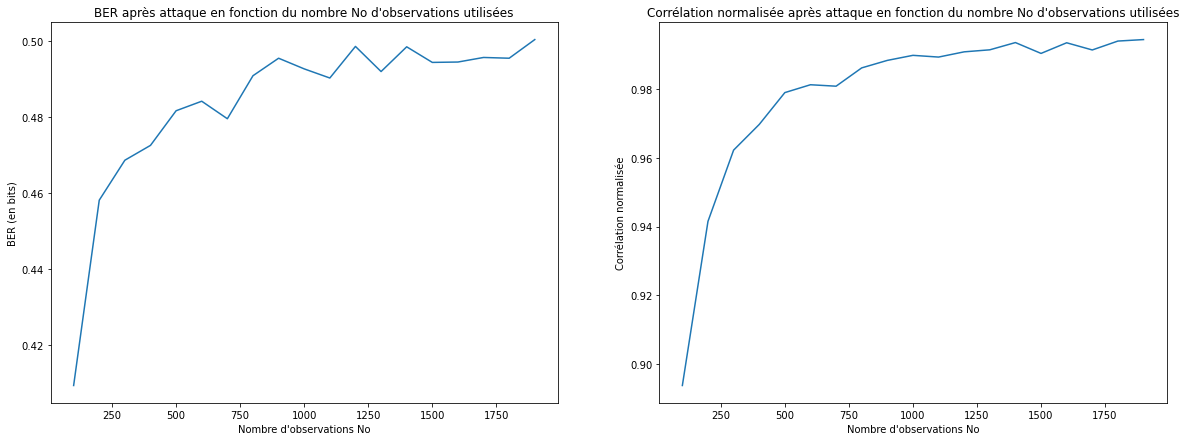

In [139]:
plt.figure(figsize=(20,7))

plt.subplot(121)
plt.title("BER après attaque en fonction du nombre No d'observations utilisées")
plt.xlabel("Nombre d'observations No")
plt.ylabel("BER (en bits)")
plt.plot(No_list, ber_list_No)

plt.subplot(122)
plt.title("Corrélation normalisée après attaque en fonction du nombre No d'observations utilisées")
plt.xlabel("Nombre d'observations No")
plt.ylabel("Corrélation normalisée")
plt.plot(No_list, corrN_list_No)

In [140]:
ber_list_alpha = []
corrN_list_alpha = []
alpha_list = np.arange(1,20)

for alpha in alpha_list:
    practical_ber, corrN_alpha = do_process(alpha,No=1000)
    ber_list_alpha.append(practical_ber)
    corrN_list_alpha.append(corrN_alpha)

alpha:  1
No:  1000
DWR:  20.0  dB
practical bit error rate:
0.1577


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(np.sum(cY != m1)/np.float(Ni))


Normalised correlation between the true key and the estimated key
[0.95935319]
practical bit error rate after security attack
0.4858


alpha:  2
No:  1000
DWR:  13.979400086720377  dB
practical bit error rate:
0.0238


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


Normalised correlation between the true key and the estimated key
[0.98934511]
practical bit error rate after security attack
0.489


alpha:  3
No:  1000
DWR:  10.45757490560675  dB
practical bit error rate:
0.0013
Normalised correlation between the true key and the estimated key
[0.99359996]
practical bit error rate after security attack
0.4849


alpha:  4
No:  1000
DWR:  7.958800173440752  dB
practical bit error rate:
0.0
Normalised correlation between the true key and the estimated key
[0.99759681]
practical bit error rate after security attack
0.4911


alpha:  5
No:  1000
DWR:  6.020599913279624  dB
practical bit error rate:
0.0
Normalised correlation between the true key and the estimated key
[0.9980917]
practical bit error rate after security attack
0.5003


alpha:  6
No:  1000
DWR:  4.436974992327127  dB
practical bit error rate:
0.0
Normalised correlation between the true key and the estimated key
[0.99898398]
practical bit error rate after security attack
0.4917


alpha:  7
No

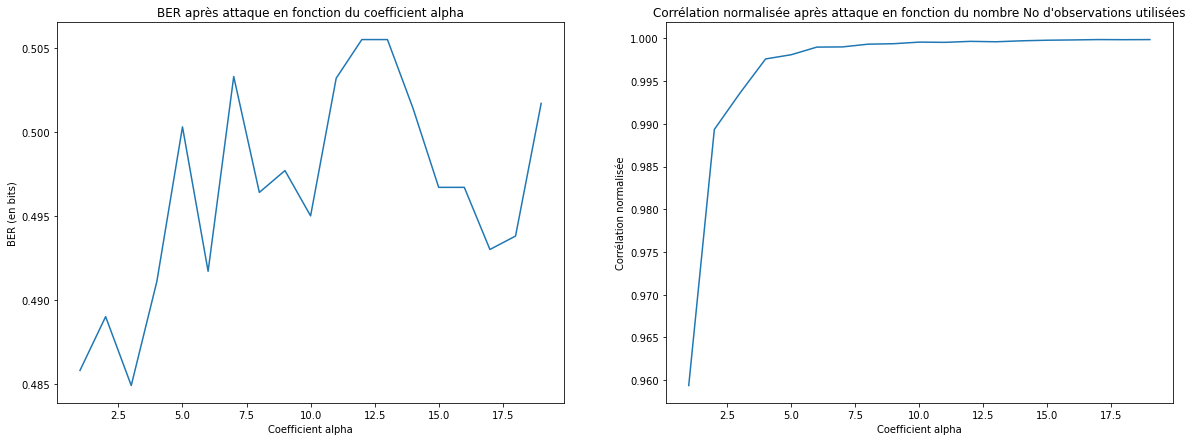

In [141]:
plt.figure(figsize=(20,7))

plt.subplot(121)
plt.title("BER après attaque en fonction du coefficient alpha")
plt.xlabel("Coefficient alpha")
plt.ylabel("BER (en bits)")
plt.plot(alpha_list, ber_list_alpha)

plt.subplot(122)
plt.title("Corrélation normalisée après attaque en fonction du nombre No d'observations utilisées")
plt.xlabel("Coefficient alpha")
plt.ylabel("Corrélation normalisée")
plt.plot(alpha_list, corrN_list_alpha)

## Scénario 2, Attaque à messages inconnus, 1bit
* Note: la fonction `np.linalg.eig` peut être utilisée pour effectuer une décomposition en valeurs et vecteurs propres.
* Note: pour effacer le message inséré, il conviendra au préalable d'estimer le bit inséré, cela peut se faire via `m_est = np.sign(np.dot(Y.T,hatk))` où `hatk` est la clé estimée
* Mettre en place l'attaque
* Etudier l'impact de $N_{o}$ et de $\alpha$ sur le BER après attaque

## Réponses

* Encore une fois, plus on augmente le nombre d'observations $N_{o}$, plus on se rapproche de la valeur de BER cible $0.5$. Cependant, contrairement au premier scénario d'attaque, il faut plus d'observations pour s'en rapprocher, et même comme cela le résultat est moins bon (plus proche de $0.47$ que de $0.5$). En effet, on ne connaît plus le message ce qui le rend plus difficile à trouver, et nécessite d'inférer la direction de plus grande variance en se basant sur des observations.
* De même, plus on augmente le coefficient $\alpha$, plus le BER se rapproche de $0.5$ pour la même raison qu'au scénario précédent. En effet, lorsque la distortion est importante, les vecteurs sont très polarisés, ce qui rend plus facile la détermination de la direction de plus grande variance par la PCA.

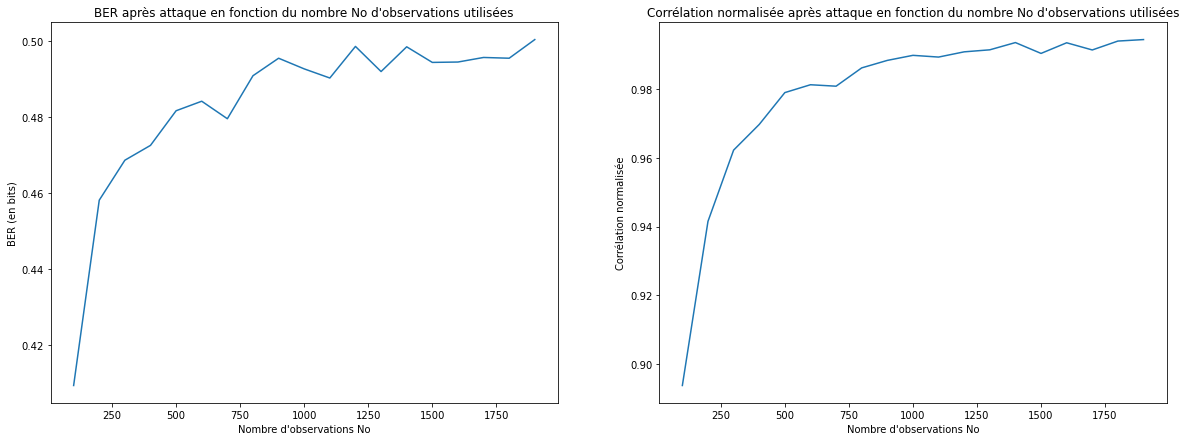

In [142]:
plt.figure(figsize=(20,7))

plt.subplot(121)
plt.title("BER après attaque en fonction du nombre No d'observations utilisées")
plt.xlabel("Nombre d'observations No")
plt.ylabel("BER (en bits)")
plt.plot(No_list, ber_list_No)

plt.subplot(122)
plt.title("Corrélation normalisée après attaque en fonction du nombre No d'observations utilisées")
plt.xlabel("Nombre d'observations No")
plt.ylabel("Corrélation normalisée")
plt.plot(No_list, np.ravel(corrN_list_No))

In [143]:
# 2dn scenario, scenario with KMA 
print('2nd Scenario')

def do_process(alpha,No):
    
    print('alpha: ',alpha)
    print('No: ',No)

    X = np.random.randn(Nv,Ni) # Generate Ni random host vectors
    k = np.random.randn(Nv,1) # Generate de Watermark
    k = k / np.sqrt(np.dot(k.T,k)) # Normalize the watermark

    m1 = np.sign(np.random.randn(Ni,1)) #Scenario with unknow messages, first bit

    K = np.dot(k,m1.T) # Generate the matrix of watermarks (each column contains m1_i*k)

    W = alpha*K

    Y = X + W # perform embedding

    # Attack
    Y_obs = Y[:,:No]

    cov = np.cov(Y_obs)
    eigvals, eigvects = np.linalg.eig(cov)

    idx = eigvals.argsort()[::-1]   
    eigvals = eigvals[idx]
    eigvects = eigvects[:,idx]
    
    hatk = eigvects[:,0]
    hatk = np.reshape(hatk,(Nv,1)) # You might need to reshape the estimated key
    corrN = norm_corr(hatk,k) # To ease the writing we use the norm_corr function
    print(f'Normalised correlation between the true key and the estimated key: {corrN[0][0]}')

    m_est = np.sign(np.dot(Y.T,hatk))
    YA = Y - alpha*np.dot(hatk,m_est.T) # KMA: perform the removal attack

    print(f'bit error rate after security attack: {ber(YA,m1,k)}')
    print('\n')
    return practical_ber, corrN


    
alpha = 2 # Tune the power of the watermark here

ber_list_No = []
corrN_list_No = []
No_list = np.arange(100,2000,100)

for No in No_list:
    practical_ber, corrN = do_process(alpha,No)
    ber_list_No.append(practical_ber)
    corrN_list_No.append(corrN)

2nd Scenario
alpha:  2
No:  100
Normalised correlation between the true key and the estimated key: 0.874449475345941
bit error rate after security attack: 0.3608


alpha:  2
No:  200
Normalised correlation between the true key and the estimated key: 0.9334131790028172
bit error rate after security attack: 0.4217


alpha:  2
No:  300
Normalised correlation between the true key and the estimated key: 0.9515189235165024


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


bit error rate after security attack: 0.4321


alpha:  2
No:  400
Normalised correlation between the true key and the estimated key: 0.953198331098135
bit error rate after security attack: 0.4378


alpha:  2
No:  500
Normalised correlation between the true key and the estimated key: 0.9722179252986443
bit error rate after security attack: 0.4504


alpha:  2
No:  600
Normalised correlation between the true key and the estimated key: 0.9732333807202465
bit error rate after security attack: 0.4454


alpha:  2
No:  700
Normalised correlation between the true key and the estimated key: 0.9798919357536815
bit error rate after security attack: 0.4679


alpha:  2
No:  800
Normalised correlation between the true key and the estimated key: 0.980738070187044
bit error rate after security attack: 0.4624


alpha:  2
No:  900
Normalised correlation between the true key and the estimated key: 0.9865547474451375
bit error rate after security attack: 0.4587


alpha:  2
No:  1000
Normalised correlation 

In [144]:
ber_list_alpha = []
corrN_list_alpha = []
alpha_list = np.arange(1,20)

for alpha in alpha_list:
    practical_ber, corrN_alpha = do_process(alpha,No=1000)
    ber_list_alpha.append(practical_ber)
    corrN_list_alpha.append(corrN_alpha)

alpha:  1
No:  1000
Normalised correlation between the true key and the estimated key: 0.9161241741080193
bit error rate after security attack: 0.3126


alpha:  2
No:  1000
Normalised correlation between the true key and the estimated key: 0.9855995488671342
bit error rate after security attack: 0.4653


alpha:  3
No:  1000
Normalised correlation between the true key and the estimated key: 0.9938997755461336
bit error rate after security attack: 0.4915


alpha:  4
No:  1000
Normalised correlation between the true key and the estimated key: 0.9968925165087241
bit error rate after security attack: 0.4975

/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)





alpha:  5
No:  1000
Normalised correlation between the true key and the estimated key: 0.9982817147480001
bit error rate after security attack: 0.4908


alpha:  6
No:  1000
Normalised correlation between the true key and the estimated key: 0.9986188096625784
bit error rate after security attack: 0.4978


alpha:  7
No:  1000
Normalised correlation between the true key and the estimated key: 0.9989440296485188
bit error rate after security attack: 0.5116


alpha:  8
No:  1000
Normalised correlation between the true key and the estimated key: 0.9991172897529165
bit error rate after security attack: 0.4982


alpha:  9
No:  1000
Normalised correlation between the true key and the estimated key: 0.9993459054157525
bit error rate after security attack: 0.4948


alpha:  10
No:  1000
Normalised correlation between the true key and the estimated key: 0.9995776154995917
bit error rate after security attack: 0.5005


alpha:  11
No:  1000
Normalised correlation between the true key and the estim

In [145]:
ber_list_alpha = []
corrN_list_alpha = []
alpha_list = np.arange(1,10)

for alpha in alpha_list:
    practical_ber, corrN_alpha = do_process(alpha,No=1000)
    ber_list_alpha.append(practical_ber)
    corrN_list_alpha.append(corrN_alpha)

alpha:  1
No:  1000
Normalised correlation between the true key and the estimated key: 0.9303664655789174
bit error rate after security attack: 0.3253


alpha:  2
No:  1000
Normalised correlation between the true key and the estimated key: 0.9867359617919714
bit error rate after security attack: 0.4554


alpha:  3
No:  1000
Normalised correlation between the true key and the estimated key: 0.9936817801482468
bit error rate after security attack: 0.4922


alpha:  4
No:  1000
Normalised correlation between the true key and the estimated key: 0.9962366003286737
bit error rate after security attack: 0.4942


alpha:  5
No:  1000
Normalised correlation between the true key and the estimated key: 0.9978631365301044


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


bit error rate after security attack: 0.4963


alpha:  6
No:  1000
Normalised correlation between the true key and the estimated key: 0.9989443391310783
bit error rate after security attack: 0.5026


alpha:  7
No:  1000
Normalised correlation between the true key and the estimated key: 0.9988472096209328
bit error rate after security attack: 0.5036


alpha:  8
No:  1000
Normalised correlation between the true key and the estimated key: 0.9994017046051216
bit error rate after security attack: 0.4982


alpha:  9
No:  1000
Normalised correlation between the true key and the estimated key: 0.9991795729546183
bit error rate after security attack: 0.5009




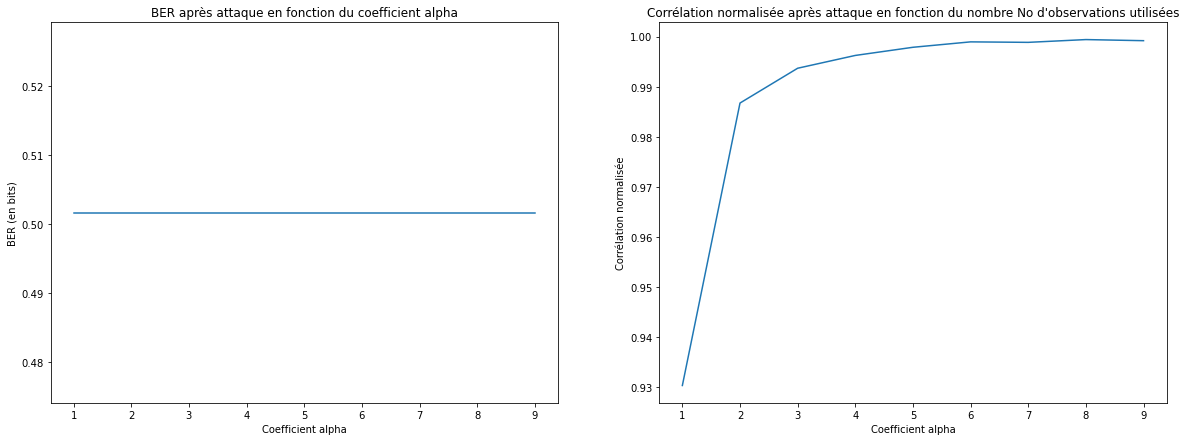

In [146]:
plt.figure(figsize=(20,7))

plt.subplot(121)
plt.title("BER après attaque en fonction du coefficient alpha")
plt.xlabel("Coefficient alpha")
plt.ylabel("BER (en bits)")
plt.plot(alpha_list, ber_list_alpha)

plt.subplot(122)
plt.title("Corrélation normalisée après attaque en fonction du nombre No d'observations utilisées")
plt.xlabel("Coefficient alpha")
plt.ylabel("Corrélation normalisée")
plt.plot(alpha_list, np.ravel(corrN_list_alpha))

## Scénario 3: Attaque à messages inconnus, 2 bits
* Vérifier que l'attaque précédente ne permet pas d'estimer les deux clés. 
* Estimer au moins l'une des clés utilisée
    * Note: on pourra utiliser l'algorithme `FastICA` pour estimer les deux composantes indépendantes 
    * Pour cela on pourra appeler la fonction fastica en spécifiant que l'analyse en composantes indépendantes s'effectuera sur un sous espace engendré par les *deux premières composantes principales* (`n_components=2`), et en récupérant les colonnes de la matrice de mélange A (obtenue via `ica.mixing_`) estimé par l'algorithme.
    * Vérifier, à l'aide de la corrélation normalisée, que cette méthode permet d'estimer la clé `k1`
* Mettre en place l'attaque qui permet d'effacter un bit sur les deux
* Etudier l'impact de $N_{o}$ et de $\alpha$ sur le BER après attaque

## Réponse

* Nous avons essayé d'appliquer la méthode du scénario 2 (PCA) pour la détermination de la clé *k1*: on observe que les corrélations normalisées ont des valeurs avoisinant 70%, ce qui n'est pas du tout satisfaisant: l'attaque précédente ne permet donc pas d'estimer les deux clés.
* Les courbes ci-dessous montrent qu'avec la méthode ICA, on est bien capable de d'estimer les deux composantes indépendantes. En particulier, pour la clé `k1`, on obtient des BER proches de 0.5 et des corrélations normalisées proches de 1, ce qui confirme l'efficacité de la méthode.
* L'impact de $N_o$ et de $\alpha$ est le même ici que pour les deux autres scénarios: le nombre d'observations améliore la qualité de la solution et le coefficient alpha rend plus simple la détermination des directions indépendantes.

In [147]:
# 3rd scenario, 2 bits

m1 = np.sign(np.random.randn(Ni,1))#Scenario with unknow messages, first bit
m2 = np.sign(np.random.randn(Ni,1))#Scenario with unknow messages, second bit

k1 = np.random.randn(Nv,1) # Generate de Watermark
k1 = k1 / np.sqrt(np.dot(k1.T,k1)) # Normalize the watermark

k2 = np.random.randn(Nv,1) # Generate de Watermark
k2 = k2 / np.sqrt(np.dot(k2.T,k2)) # Normalize the watermark

In [148]:
# 3rd scenario,n 2 bits, but applying method of scenario 2
def do_process_with_old_method(alpha,No):

    X = np.random.randn(Nv,Ni) # Generate Ni random host vectors
    K = np.dot(k1,m1.T) + np.dot(k2,m2.T) # Generate the matrix of watermarks (each column contains m1_i*k)
    W = alpha*K
    Y = X + W # perform embedding
    Y_obs = Y[:,:No]

    cov = np.cov(Y_obs)
    eigvals, eigvects = np.linalg.eig(cov)

    idx = eigvals.argsort()[::-1]   
    eigvals = eigvals[idx]
    eigvects = eigvects[:,idx]
    
    hatk_1 = eigvects[:,0]
    hatk_2 = eigvects[:,1]

    hatk_1 = hatk_1/np.linalg.norm(hatk_1) # Normalize the vector
    hatk_1 = np.reshape(hatk_1,(Nv,1)) # Reshape for upcoming comparisons

    hatk_2 = hatk_2/np.linalg.norm(hatk_2)
    hatk_2 = np.reshape(hatk_2,(Nv,1))

    # It is uncertain which key hatk_1 and hatk_2 correspond to, so we need to test
    corrN_v1 = norm_corr(hatk_1,k1) # Compute the Normalised correlation
    corrN_v2 = norm_corr(hatk_1,k2)
    
    if(corrN_v1 < corrN_v2) : hatk_1, hatk_2 = hatk_2, hatk_1

    corrN_1 = norm_corr(hatk_1,k1)
    print(f'Normalised correlation between the estimated key and k1: {corrN_1[0][0]}')

    corrN_2 = norm_corr(hatk_2,k2) # Compute the Normalised correlation
    print(f'Normalised correlation between the estimated key and k2: {corrN_2[0][0]}')

    m1_est = np.sign(np.dot(Y.T,hatk_1))
    m2_est = np.sign(np.dot(Y.T,hatk_2))
    
    YA_1 = Y - alpha*np.dot(hatk_1,m1_est.T) # KMA: perform the removal attack
    YA_2 = Y - alpha*np.dot(hatk_2,m2_est.T)
    
    ber1 = ber(YA_1,m1,k1)
    ber2 = ber(YA_2,m2,k2)
    print(f'bit error rate after security attack for the first bit: {ber1}')
    print(f'bit error rate after security attack for the second bit: {ber2}')
    print('\n\n')

# One example, can be used to draw plots
for No in range(100,2000,100):
    do_process_with_old_method(alpha,No)

Normalised correlation between the estimated key and k1: 0.7063655019164785
Normalised correlation between the estimated key and k2: 0.7520177937735308
bit error rate after security attack for the first bit: 0.01
bit error rate after security attack for the second bit: 0.0038



Normalised correlation between the estimated key and k1: 0.6923629682174282
Normalised correlation between the estimated key and k2: 0.7370000783732824
bit error rate after security attack for the first bit: 0.0073
bit error rate after security attack for the second bit: 0.0012



Normalised correlation between the estimated key and k1: 0.6991707072287925
Normalised correlation between the estimated key and k2: 0.7434900433848068
bit error rate after security attack for the first bit: 0.0075
bit error rate after security attack for the second bit: 0.0015



Normalised correlation between the estimated key and k1: 0.7833679963715808
Normalised correlation between the estimated key and k2: 0.7417316796719707


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


bit error rate after security attack for the first bit: 0.0163
bit error rate after security attack for the second bit: 0.019



Normalised correlation between the estimated key and k1: 0.7571653656238585
Normalised correlation between the estimated key and k2: 0.7137499021902685
bit error rate after security attack for the first bit: 0.0034
bit error rate after security attack for the second bit: 0.0119



Normalised correlation between the estimated key and k1: 0.6995507772535587
Normalised correlation between the estimated key and k2: 0.743547331041385
bit error rate after security attack for the first bit: 0.0092
bit error rate after security attack for the second bit: 0.0015



Normalised correlation between the estimated key and k1: 0.7478911182630495
Normalised correlation between the estimated key and k2: 0.704217736253069
bit error rate after security attack for the first bit: 0.002
bit error rate after security attack for the second bit: 0.0099



Normalised correlation betwe

In [149]:
def do_process(alpha,No):

    print('alpha: ',alpha)
    print('No: ',No)

    X = np.random.randn(Nv,Ni) # Generate Ni random host vectors

    K = np.dot(k1,m1.T) + np.dot(k2,m2.T) # Generate the matrix of watermarks (each column contains m1_i*k)

    W = alpha*K

    Y = X + W # perform embedding
    
    Y_obs = Y[:,:No]

    ica = FastICA(n_components=2)
    ica.fit(Y_obs.T)

    hatk_1 = ica.mixing_[:,1]
    hatk_2 = ica.mixing_[:,0]
    
    hatk_1 = hatk_1/np.linalg.norm(hatk_1) # Normalize the vector
    hatk_1 = np.reshape(hatk_1,(Nv,1)) # Reshape for upcoming comparisons

    hatk_2 = hatk_2/np.linalg.norm(hatk_2)
    hatk_2 = np.reshape(hatk_2,(Nv,1))

    # It is uncertain which key hatk_1 and hatk_2 correspond to, so we need to test
    corrN_v1 = norm_corr(hatk_1,k1) # Compute the Normalised correlation
    corrN_v2 = norm_corr(hatk_1,k2)
    
    if(corrN_v1 < corrN_v2) : hatk_1, hatk_2 = hatk_2, hatk_1

    corrN_1 = norm_corr(hatk_1,k1)
    print(f'Normalised correlation between the estimated key and k1: {corrN_1[0][0]}')

    corrN_2 = norm_corr(hatk_2,k2) # Compute the Normalised correlation
    print(f'Normalised correlation between the estimated key and k2: {corrN_2[0][0]}')

    YA_1 = np.zeros((Nv,Ni)) # Perform the attack

    m1_est = np.sign(np.dot(Y.T,hatk_1))
    m2_est = np.sign(np.dot(Y.T,hatk_2))
    
    YA_1 = Y - alpha*np.dot(hatk_1,m1_est.T) # KMA: perform the removal attack
    YA_2 = Y - alpha*np.dot(hatk_2,m2_est.T)
    
    ber1 = ber(YA_1,m1,k1)
    ber2 = ber(YA_2,m2,k2)
    print(f'bit error rate after security attack for the first bit: {ber1}')
    print(f'bit error rate after security attack for the second bit: {ber2}')
    print('\n\n')
    # We only return the BER and correlation for the first bit
    return ber1, corrN_1[0][0]

alpha = 2 # Tune the power of the watermark here

ber_list_No = []
corrN_list_No = []
No_list = np.arange(100,2000,100)

# One example, can be used to draw plots
for No in range(100,2000,100):
    practical_ber, corrN = do_process(alpha,No)
    ber_list_No.append(practical_ber)
    corrN_list_No.append(corrN)

alpha:  2
No:  100
Normalised correlation between the estimated key and k1: 0.8344140160011109
Normalised correlation between the estimated key and k2: 0.8750623463476104


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


bit error rate after security attack for the first bit: 0.3192
bit error rate after security attack for the second bit: 0.353



alpha:  2
No:  200
Normalised correlation between the estimated key and k1: 0.9336781420911895
Normalised correlation between the estimated key and k2: 0.9217404038696934
bit error rate after security attack for the first bit: 0.4173
bit error rate after security attack for the second bit: 0.3981



alpha:  2
No:  300


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


Normalised correlation between the estimated key and k1: 0.9538208445013925
Normalised correlation between the estimated key and k2: 0.9465336321611663
bit error rate after security attack for the first bit: 0.4269
bit error rate after security attack for the second bit: 0.4302



alpha:  2
No:  400


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


Normalised correlation between the estimated key and k1: 0.9512085431909412
Normalised correlation between the estimated key and k2: 0.9620906639150659


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


bit error rate after security attack for the first bit: 0.439
bit error rate after security attack for the second bit: 0.4464



alpha:  2
No:  500
Normalised correlation between the estimated key and k1: 0.9690046320124476
Normalised correlation between the estimated key and k2: 0.9686150651917365
bit error rate after security attack for the first bit: 0.4511
bit error rate after security attack for the second bit: 0.4479



alpha:  2
No:  600


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


Normalised correlation between the estimated key and k1: 0.9790202824009446
Normalised correlation between the estimated key and k2: 0.9622587141249206
bit error rate after security attack for the first bit: 0.4565
bit error rate after security attack for the second bit: 0.442



alpha:  2
No:  700


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


Normalised correlation between the estimated key and k1: 0.9798004301347578
Normalised correlation between the estimated key and k2: 0.9776060857938209


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


bit error rate after security attack for the first bit: 0.4522
bit error rate after security attack for the second bit: 0.4524



alpha:  2
No:  800
Normalised correlation between the estimated key and k1: 0.9821229692648465
Normalised correlation between the estimated key and k2: 0.9813673159373769


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


bit error rate after security attack for the first bit: 0.4562
bit error rate after security attack for the second bit: 0.4531



alpha:  2
No:  900
Normalised correlation between the estimated key and k1: 0.9838055488837898
Normalised correlation between the estimated key and k2: 0.9837923886915346
bit error rate after security attack for the first bit: 0.4589
bit error rate after security attack for the second bit: 0.4582


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)





alpha:  2
No:  1000
Normalised correlation between the estimated key and k1: 0.9845549700012088
Normalised correlation between the estimated key and k2: 0.9834959211967529
bit error rate after security attack for the first bit: 0.4614
bit error rate after security attack for the second bit: 0.4653



alpha:  2
No:  1100


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


Normalised correlation between the estimated key and k1: 0.987053689360194
Normalised correlation between the estimated key and k2: 0.9865633910215856
bit error rate after security attack for the first bit: 0.4624
bit error rate after security attack for the second bit: 0.4658



alpha:  2
No:  1200


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


Normalised correlation between the estimated key and k1: 0.9866738694377131
Normalised correlation between the estimated key and k2: 0.9854826674319852
bit error rate after security attack for the first bit: 0.4709
bit error rate after security attack for the second bit: 0.4649



alpha:  2
No:  1300


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


Normalised correlation between the estimated key and k1: 0.9892811355017914
Normalised correlation between the estimated key and k2: 0.9862095317607669
bit error rate after security attack for the first bit: 0.4714
bit error rate after security attack for the second bit: 0.4623



alpha:  2
No:  1400


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


Normalised correlation between the estimated key and k1: 0.9900663406970667
Normalised correlation between the estimated key and k2: 0.9903119832031764
bit error rate after security attack for the first bit: 0.4712
bit error rate after security attack for the second bit: 0.4745



alpha:  2
No:  1500


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


Normalised correlation between the estimated key and k1: 0.9856649586942938
Normalised correlation between the estimated key and k2: 0.9901594932656907
bit error rate after security attack for the first bit: 0.4624
bit error rate after security attack for the second bit: 0.463



alpha:  2
No:  1600


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


Normalised correlation between the estimated key and k1: 0.9921472847155828
Normalised correlation between the estimated key and k2: 0.9911801944277057
bit error rate after security attack for the first bit: 0.4735
bit error rate after security attack for the second bit: 0.4677



alpha:  2
No:  1700


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


Normalised correlation between the estimated key and k1: 0.99053974016576
Normalised correlation between the estimated key and k2: 0.9893844044739256
bit error rate after security attack for the first bit: 0.4628
bit error rate after security attack for the second bit: 0.4545



alpha:  2
No:  1800


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


Normalised correlation between the estimated key and k1: 0.9917099099601743
Normalised correlation between the estimated key and k2: 0.9918948236985602
bit error rate after security attack for the first bit: 0.4683
bit error rate after security attack for the second bit: 0.4637



alpha:  2
No:  1900


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


Normalised correlation between the estimated key and k1: 0.9923118134026656
Normalised correlation between the estimated key and k2: 0.9920813379765768
bit error rate after security attack for the first bit: 0.4675
bit error rate after security attack for the second bit: 0.4697





/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


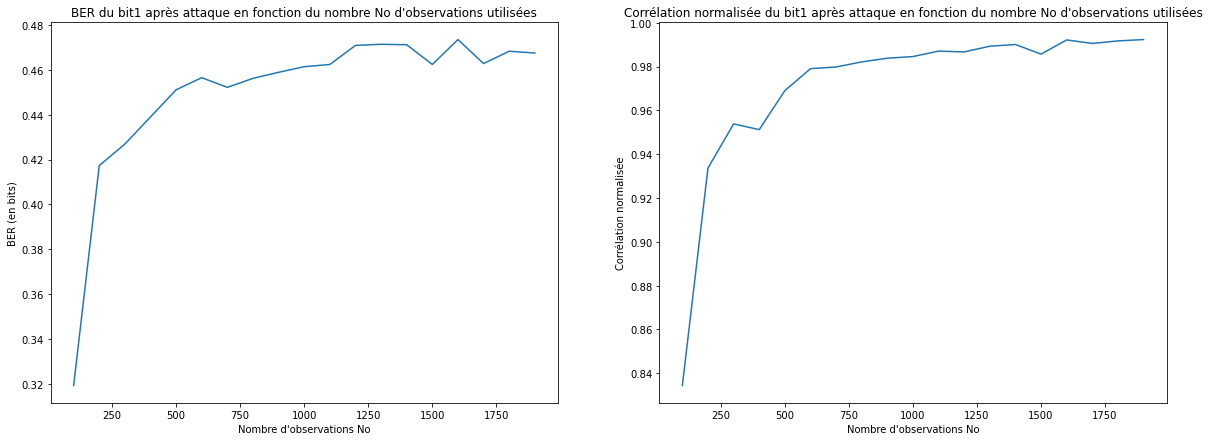

In [150]:
plt.figure(figsize=(20,7))

plt.subplot(121)
plt.title("BER du bit1 après attaque en fonction du nombre No d'observations utilisées")
plt.xlabel("Nombre d'observations No")
plt.ylabel("BER (en bits)")
plt.plot(No_list, ber_list_No)

plt.subplot(122)
plt.title("Corrélation normalisée du bit1 après attaque en fonction du nombre No d'observations utilisées")
plt.xlabel("Nombre d'observations No")
plt.ylabel("Corrélation normalisée")
plt.plot(No_list, np.ravel(corrN_list_No))

In [151]:
ber_list_alpha = []
corrN_list_alpha = []
alpha_list = np.arange(1,10)

for alpha in alpha_list:
    practical_ber, corrN_alpha = do_process(alpha,No=1000)
    ber_list_alpha.append(practical_ber)
    corrN_list_alpha.append(corrN_alpha)

alpha:  1
No:  1000
Normalised correlation between the estimated key and k1: 0.8829630523071261
Normalised correlation between the estimated key and k2: 0.8773358201176646


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


bit error rate after security attack for the first bit: 0.2999
bit error rate after security attack for the second bit: 0.2833



alpha:  2
No:  1000
Normalised correlation between the estimated key and k1: 0.9820682309957506
Normalised correlation between the estimated key and k2: 0.9870139266671931
bit error rate after security attack for the first bit: 0.4535
bit error rate after security attack for the second bit: 0.4649



alpha:  3
No:  1000


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


Normalised correlation between the estimated key and k1: 0.9935630315938184
Normalised correlation between the estimated key and k2: 0.992349165737338
bit error rate after security attack for the first bit: 0.4994
bit error rate after security attack for the second bit: 0.4943



alpha:  4
No:  1000


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


Normalised correlation between the estimated key and k1: 0.9962942706315214
Normalised correlation between the estimated key and k2: 0.9963331894741843


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


bit error rate after security attack for the first bit: 0.4867
bit error rate after security attack for the second bit: 0.4924



alpha:  5
No:  1000
Normalised correlation between the estimated key and k1: 0.9982568032256174
Normalised correlation between the estimated key and k2: 0.9979593991028926
bit error rate after security attack for the first bit: 0.492
bit error rate after security attack for the second bit: 0.4993



alpha:  6
No:  1000


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


Normalised correlation between the estimated key and k1: 0.9983169074974323
Normalised correlation between the estimated key and k2: 0.9985008035993816
bit error rate after security attack for the first bit: 0.498
bit error rate after security attack for the second bit: 0.5021



alpha: 

/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


 7
No:  1000
Normalised correlation between the estimated key and k1: 0.99868165015409
Normalised correlation between the estimated key and k2: 0.9989068206189234
bit error rate after security attack for the first bit: 0.4912
bit error rate after security attack for the second bit: 0.4882



alpha:  8
No:  1000


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


Normalised correlation between the estimated key and k1: 0.9988677064666089
Normalised correlation between the estimated key and k2: 0.9989465554523278
bit error rate after security attack for the first bit: 0.4932
bit error rate after security attack for the second bit: 0.4977



alpha:  9
No:  1000


/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


Normalised correlation between the estimated key and k1: 0.9991150611074557
Normalised correlation between the estimated key and k2: 0.9991205052419945
bit error rate after security attack for the first bit: 0.4893
bit error rate after security attack for the second bit: 0.4942





/var/folders/fx/rw1v2lnj1vs1g3c69ms3ck940000gn/T/ipykernel_12701/430683797.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.sum(c != m)/np.float(Ni)


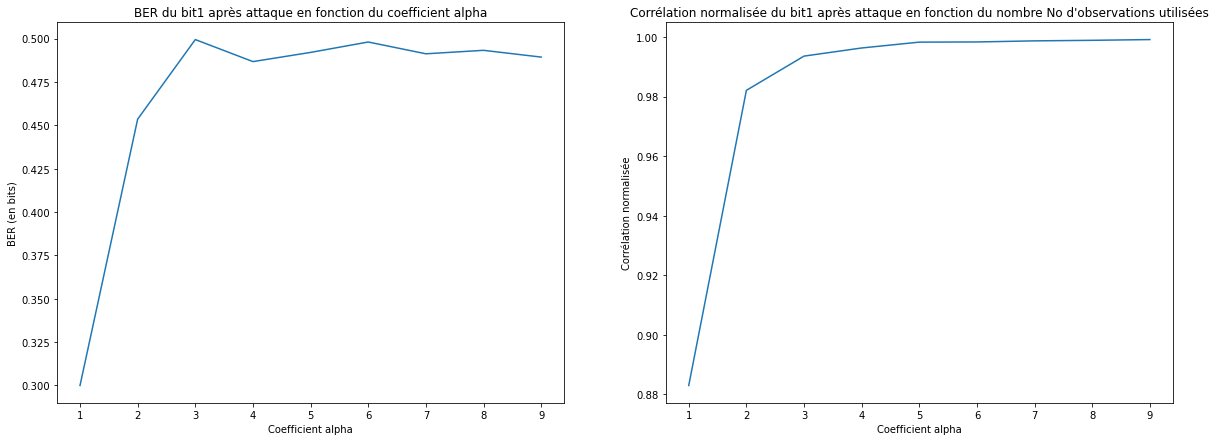

In [152]:
plt.figure(figsize=(20,7))

plt.subplot(121)
plt.title("BER du bit1 après attaque en fonction du coefficient alpha")
plt.xlabel("Coefficient alpha")
plt.ylabel("BER (en bits)")
plt.plot(alpha_list, ber_list_alpha)

plt.subplot(122)
plt.title("Corrélation normalisée du bit1 après attaque en fonction du nombre No d'observations utilisées")
plt.xlabel("Coefficient alpha")
plt.ylabel("Corrélation normalisée")
plt.plot(alpha_list, corrN_list_alpha)

## Pour conclure: Etude de la robustesse
* Calculer le taux d'erreur (BER pour Bit Error Rate) théorique après ajout de bruit (voir cours)
* Etudier l'évolution de la robustesse (via le BER) en fonction de la distortion $\alpha$ 
* Quel compromis observe-t-on entre la sécurité et la robustesse?

## Réponse

Pour cette étude de robustesse, nous nous baserons sur le deuxième scénario.
Même avec bruit, il semble que l'attaque reste efficace (corrélation proche de 1 et BER proche de 0.5).

Il semble toutefois improbable que les indicateurs varient si peu avec $\alpha$, et nous soupçonnons donc une erreur d'implémentation.
Nous nous attendions à observer un compromis entre sécurité et robustesse: une plus grande sécurité implique une plus faible robustesse.

In [153]:
def do_process_with_noise(alpha, No, noise_std):
    
    X = np.random.randn(Nv,Ni) # Generate Ni random host vectors
    k = np.random.randn(Nv,1) # Generate de Watermark
    k = k / np.sqrt(np.dot(k.T,k)) # Normalize the watermark

    m1 = np.sign(np.random.randn(Ni,1)) # Scenario with unknow messages, first bit

    K = np.dot(k,m1.T) # Generate the matrix of watermarks (each column contains m1_i*k)
    W = alpha*K

    Y = X + W # perform embedding
    Z = Y + np.random.normal(loc=0, scale=noise_std)

    # Attack
    Z_obs = Z[:,:No]

    cov = np.cov(Z_obs)
    eigvals, eigvects = np.linalg.eig(cov)

    idx = eigvals.argsort()[::-1]   
    eigvals = eigvals[idx]
    eigvects = eigvects[:,idx]
    
    hatk = eigvects[:,0]
    hatk = np.reshape(hatk,(Nv,1)) # You might need to reshape the estimated key
    corrN = norm_corr(hatk,k) # To ease the writing we use the norm_corr function

    m_est = np.sign(np.dot(Z.T,hatk))
    ZA = Z - alpha*np.dot(hatk,m_est.T) # KMA: perform the removal attack

    return practical_ber, corrN

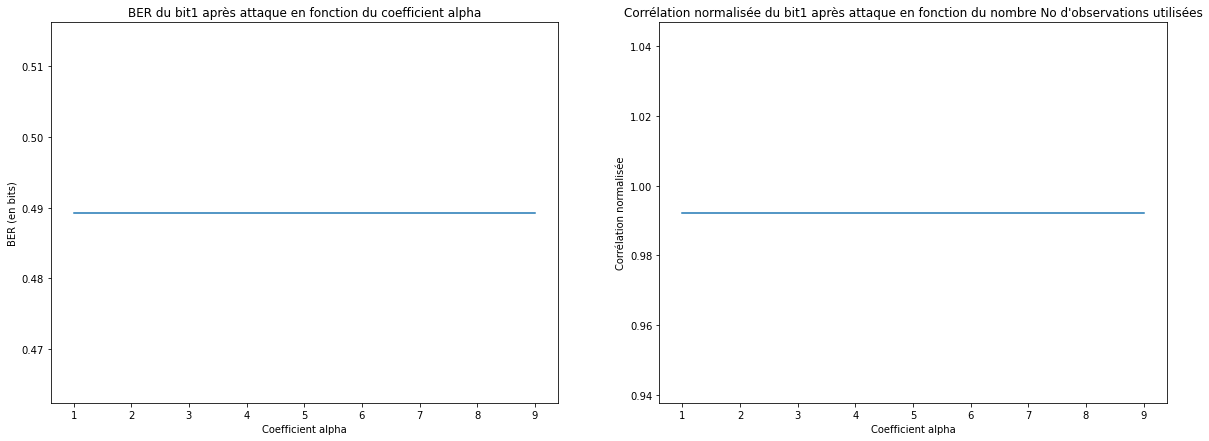

In [154]:
ber_list_alpha = []
corrN_list_alpha = []
No_list = np.arange(100,2000,100)

alpha_list = np.arange(1,10)

for alpha in alpha_list:
    practical_ber, corrN_alpha = do_process_with_noise(alpha,No=1000, noise_std=10)
    ber_list_alpha.append(practical_ber)
    corrN_list_alpha.append(corrN)
    
plt.figure(figsize=(20,7))

plt.subplot(121)
plt.title("BER du bit1 après attaque en fonction du coefficient alpha")
plt.xlabel("Coefficient alpha")
plt.ylabel("BER (en bits)")
plt.plot(alpha_list, ber_list_alpha)

plt.subplot(122)
plt.title("Corrélation normalisée du bit1 après attaque en fonction du nombre No d'observations utilisées")
plt.xlabel("Coefficient alpha")
plt.ylabel("Corrélation normalisée")
plt.plot(alpha_list, corrN_list_alpha)

# Stéganalyse par apprentissage
## Mise en route:
* Récupèrer les caractéristiques ici: https://nextcloud.univ-lille.fr/index.php/s/i6xr4JykqAASapN
* On charge les caractéristiques extraites à partir des images Cover et Stego pour d=3 (dimension de l'histogramme multivarié) et T=3 (seuil)

In [155]:
cover = np.loadtxt('Features/cover-spam-N=3-T=3.csv')
stego = np.loadtxt('Features/stego-0.20-lsb-spam-N=3-T=3.csv')

In [156]:
print(cover.shape)
print(stego.shape)

(10000, 686)
(10000, 686)


**Quelle est la dimension des caractéristiques ? Pourquoi ?**

On a 10000 échantillons respectifs d'images cover et stégo contenant chacun les *bins* d'un histogramme multivarié associé à une image.
Pour $N=3$ et $T=3$, on a $2 \times (2T+1)^N = 686$ caractéristiques.

**Entrainer un classifieur linéaire avec 5000 images en apprentissage et en test (effectuer une permutation pseudo-aléatoire des images avant l'apprentissage)**

In [157]:
def prepare_data(cover, stego, N_train):
    """
    Generates training and test sets from cover and stego images. The train data is of size N_train.
    Returns a tuple : (data_train, t_train, data_test, t_test)
    """
    
    N = cover.shape[0] # number of examples
    
    # Label the data: 0 is for cover images and label 1 is for stego images
    cover_labelled = np.hstack([np.zeros(N).reshape((N,1)),cover])
    stego_labelled = np.hstack([np.ones(N).reshape((N,1)),stego])
    labelled_data = np.vstack([cover_labelled, stego_labelled]) 

    # Shuffle the data
    np.random.shuffle(labelled_data)

    # Create train and test sets
    train = labelled_data[:N_train]
    test = labelled_data[N_train:]

    # Separating data from labels
    t_train = train[:, 0] # 't' for 'target'
    data_train = train[:,1:]

    t_test = test[:,0]
    data_test = test[:,1:]
    
    return data_train, t_train, data_test, t_test

In [158]:
# Discriminant Analysis (LDA for linear classification, QDA for non-linear classification)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis


N_train = 5000
data_train, t_train, data_test, t_test = prepare_data(cover, stego, N_train)

lda = LinearDiscriminantAnalysis().fit(data_train, t_train)
qda = QuadraticDiscriminantAnalysis().fit(data_train, t_train)

score_lda = lda.score(data_test, t_test)
score_qda = qda.score(data_test, t_test)

print(f"Avec un classifieur linéaire (LDA), on obtient un score de {score_lda}.")
print(f"Avec un classifieur non-linéaire (QDA), on obtient un score de {score_qda}.")

Avec un classifieur linéaire (LDA), on obtient un score de 0.8814.
Avec un classifieur non-linéaire (QDA), on obtient un score de 0.7697333333333334.


Avec une analyse discriminante linéaire, on obtient un taux d'erreur proche de 12%, ce qui laisse penser que les données sont presque linéairement séparables. Ainsi, il semble raisonnable de vouloir utiliser de l'apprentissage automatisé pour détecter la présence ou non de messages stéganographiés.
La limite de ce procédé est qu'il faut une grande quantité de données labellisées pour l'entraînement du modèle.

**Effectuer plusieurs entrainements/test successifs sur des ensembles d'apprentissage et de test différents (permutations différentes), commentez la variabilité**

In [159]:
N_train = 5000
N_iter = 10
scores = []

for _ in range(N_iter):
    data_train, t_train, data_test, t_test = prepare_data(cover, stego, N_train)
    lda = LinearDiscriminantAnalysis().fit(data_train, t_train)
    scores.append(lda.score(data_test, t_test))
    
print(f"Over {N_iter} iterations, the score obtained by LDA is between {np.min(scores)} and {np.max(scores)}.")

Over 10 iterations, the score obtained by LDA is between 0.874 and 0.886.


Sur 10 itérations avec des ensembles d'apprentissage/test différents, le score varie de 1% au plus. Il semble donc y avoir peu de variabilité dans les résultats observés ci-dessus.

**Comparer avec les caractéristiques produites pour N = 2 et T = 4 (fournies), expliquer la différence de performance**

In [160]:
cover_2 = np.loadtxt('Features/cover-spam-N=2-T=4.csv')
stego_2 = np.loadtxt('Features/stego-0.20-lsb-spam-N=2-T=4.csv')

print(cover_2.shape)
print(stego_2.shape)

(10000, 162)
(10000, 162)


In [161]:
N_train = 5000
data_train, t_train, data_test, t_test = prepare_data(cover_2, stego_2, N_train)

lda = LinearDiscriminantAnalysis().fit(data_train, t_train)
qda = QuadraticDiscriminantAnalysis().fit(data_train, t_train)

score_lda = lda.score(data_test, t_test)
score_qda = qda.score(data_test, t_test)

print(f"Avec un classifieur linéaire (LDA), on obtient un score de {score_lda}.")
print(f"Avec un classifieur non-linéaire (QDA), on obtient un score de {score_qda}.")

Avec un classifieur linéaire (LDA), on obtient un score de 0.7785333333333333.
Avec un classifieur non-linéaire (QDA), on obtient un score de 0.6970666666666666.


Nous observons une baisse de la qualité des prédictions d'environ 10%.
Cette fois, on a $N=2$ et $T=4$, d'où $2 \times (2T+1)^N = 162$ caractéristiques. Autrement dit, les histogrammes sont plus "grossiers".
Or, la détection d'un message caché requiert un certain niveau de précision, ce qui explique que les résultats obtenus soient moins bons.